In [1]:
%config Completer.use_jedi = False

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import warnings
from pprint import pprint

warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=UserWarning)

In [4]:
import os
import json
import itertools
from time import time
from collections import defaultdict

import regex
import numpy as np
import pandas as pd
import editdistance

from tqdm import tqdm_notebook as tqdm

import matplotlib.pyplot as plt
from ctcdecode import CTCBeamDecoder

import torchaudio

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, BatchSampler, SequentialSampler, RandomSampler

from src.audio_utils import open_audio
from src.audio_utils import make_transform, get_default_audio_transforms
from src.audio_utils import AudioTransformsChain, AudioTransformsExclusive
from src.audio_utils import SpectrogramTransform, compute_log_mel_spectrogram

from src.datasets import AudioDataset
from src.datasets import AudioDatasetSampler, collate_fn

from src.datasets import manifest_train_test_split
from src.datasets import convert_libri_manifest_to_common_voice
from src.datasets import convert_open_stt_manifest_to_common_voice

from src.deepspeech import Model

from src.decoding import calc_wer, calc_wer_for_batch
from src.decoding import decode, greedy_decoder, beam_search_decode, fast_beam_search_decode

from src.optimization import get_prediction, get_model_results
from src.optimization import get_prediction, get_model_results, validate, training

Распределите в команде гпу, задайте свой номер.

In [5]:
! nvidia-smi

Tue Mar 23 14:06:33 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.80.02    Driver Version: 450.80.02    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:00:1B.0 Off |                    0 |
| N/A   35C    P0    35W / 300W |      7MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  On   | 00000000:00:1C.0 Off |                    0 |
| N/A   

In [6]:
# Set proper device for computations,
dtype, device, cuda_device_id = torch.float32, None, 0
os.environ["CUDA_VISIBLE_DEVICES"] = '{0}'.format(str(cuda_device_id) if cuda_device_id is not None else '')
if cuda_device_id is not None and torch.cuda.is_available():
    device = 'cuda:{0:d}'.format(0)
else:
    device = torch.device('cpu')
    
print(f'dtype: {dtype}, device: {device}, cuda_device_id {cuda_device_id}')

dtype: torch.float32, device: cuda:0, cuda_device_id 0


Импортируем полезную либу `attrdict`. Чем она хороша: позволяет обращаться к элементам словаря, как к его атрибутам

In [7]:
from attrdict import AttrDict

# Работа с аудио и текстом

В распознавании речи нейронная сеть обучается на парах аудио+текст.

Давайте научимся открывать аудиофайлы и подготавливать их для работы с нейронной сетью.



На лекциях мы обсуждали, что аудио может быть записано с разной частотой дискретизации (sample rate), но для обучения нейронной сети обычно все аудио приводят к одной частоте дискретизации. (В этом проекте мы будем использовать sample rate 8000).

Так же аудио может быть одноканальным или многоканальным. Проблема с многоканальным аудио может быть в том, что речь в двух каналах может звучать одновременно, такие аудио надо разделять на 2 дорожки. В нашем же случае данные подобраны таким образом, что такой ситуации не возникет, поэтому несколько каналов можно просто усреднить.


Будем использовать библиотеку `torchaudio` [docs](https://pytorch.org/audio/).

Реализуйте функцию `open_audio`, которая открывает аудио (искать [тут](https://pytorch.org/audio/stable/torchaudio.html)), усредняет аудио по всем каналам (это можно сделать обычным усреднением) и приводит к необходимой частоте дискретизации (искать [тут](https://pytorch.org/audio/stable/transforms.html)).

In [8]:
! ls test_files/

spectrogram.npy  test_dataset.txt	   test_open_audio.npy
test_audio.mp3	 test_open_audio16000.npy
test_audio.opus  test_open_audio2.npy


Запустите тесты, чтобы проверить себя.
<img src="images/tests_are_all_we_need.png" width="400" height="600">


**Перед каждым запуском тестов не забывайте сохранять ноутбук.**

In [13]:
! pytest tests/test_open_audio.py

Теперь давайте откроем аудио, и послушаем, что у нас получилось.

In [9]:
from IPython.display import Audio

In [10]:
sample_rate = 8000
audio, audio_len = open_audio('test_files/test_audio.mp3', sample_rate)
Audio(data=audio.numpy(), rate=sample_rate)

Так же послушать аудио можно через путь к аудио файлу.

Можно заметить, что звучание немного поменялось. Это произошло из-за того, что мы поменяли оригинальный sample rate 48000Hz на 8000Hz.

In [11]:
Audio('test_files/test_audio.mp3')

Speech2text  —  это не только speech, но и text, поэтому теперь давайте поговорим о предобработке текста. 

Первым шагом необходимо привести текст к нижнему регистру и удалить пунктуацию. Если на этом этапе в тексте содержатся символы кроме русского алфавита и пробела (например, цифры), то такие примеры лучше вообще убрать из обучающей выборки (если просто убрать символ из строки, то может нарушиться соответствие аудио-текст).

В размеченных данных для обучения и валидации уже произедена очистка и удаление ненужных символов, поэтому нам надо только извлечь токены из текста.

В качестве токенов для обучения нейронной сети будем использовать буквы русского алфавита и пробел. Так же, как было сказано в лекциях, нам потребуется специальный символ `<blank>` для построения выравниваний.

In [12]:
alphabet = ['а', 'б', 'в', 'г', 'д', 'е', 'ё', 'ж', 'з', 'и', 'й', 'к',
            'л', 'м', 'н', 'о', 'п', 'р', 'с', 'т', 'у', 'ф', 'х', 'ц',
            'ч', 'ш', 'щ', 'ь', 'ы', 'ъ', 'э', 'ю', 'я',
            ' ', '<blank>']

Но, естественно, в таком виде передавать буквы в нейронную сеть мы не можем — их нужно закодировать в числа. Для этого будем использовать уже готовую функцию Vocab.

Обратите внимание, что Vocab добавляет дополнительный токен `<unk>`, ответственный за все символы, которых нет в словаре.

In [13]:
from vocabulary import Vocab
vocab = Vocab(alphabet)

The `unk_token` '<unk>' wasn't found in the tokens. Adding the `unk_token` to the end of the Vocab.


Попрактикуйтесь с Vocab. Для того, чтобы понять все возможности Vocab можно заглянуть в код vocabulary.py и почитать докстринги.

* переведите "привет" в индексы
* переведите [11, 0, 11, 33, 4, 5, 12, 0] в текст
* что будет если перевести в индексы слово "hi"?
* а [44, 5] в текст?


In [14]:
vocab.lookup_indices('привет')

[16, 17, 9, 2, 5, 19]

In [15]:
vocab.lookup_tokens([11, 0, 11, 33, 4, 5, 12, 0])

['к', 'а', 'к', ' ', 'д', 'е', 'л', 'а']

In [16]:
vocab.lookup_indices('hi')

[35, 35]

In [17]:
try:
    vocab.lookup_indices([45, 5])
except Exception as ex:
    print(ex)

lookup_indices() Expected a value of type 'List[str]' for argument '_1' but instead found type 'list'.
Position: 1
Value: [45, 5]
Declaration: lookup_indices(__torch__.torch.classes.torchtext.Vocab _0, str[] _1) -> (int[] _0)
Cast error details: Unable to cast Python instance to C++ type (compile in debug mode for details)


Какие еще у Vocab возможности?

Если в процессе исследования вы изменили текущий vocab (путем добавления нового токена, например), не забудьте вернуть vocab к начальному состоянию  `vocab = Vocab(alphabet)`

Давайте извлечем из Vocab и сохраним в переменные два важных значения - длину алфавита и значения индекса `<blank>`.
    
Эти значения нам еще много раз пригодятся.

In [18]:
def get_num_tokens(vocab):
    ### write your code here ###
    num_tokens = len(vocab.tokens2indices())
    return num_tokens

def get_blank_index(vocab):
    ### write your code here ###
    blank_index = vocab['<blank>']
    return blank_index

In [22]:
! pytest tests/test_num_tokens.py
! pytest tests/test_blank_index.py

Don't forget to save Jupyter Notebook! 


============================= test session starts ==============================
platform linux -- Python 3.6.9, pytest-6.2.2, py-1.10.0, pluggy-0.13.1
rootdir: /home/mnakhodnov/sirius-stt, configfile: pytest.ini
collected 1 item                                                               

tests/test_num_tokens.py .                                               [100%]

============================== 1 passed in 1.79s ===============================
Don't forget to save Jupyter Notebook! 


============================= test session starts ==============================
platform linux -- Python 3.6.9, pytest-6.2.2, py-1.10.0, pluggy-0.13.1
rootdir: /home/mnakhodnov/sirius-stt, configfile: pytest.ini
collected 1 item                                                               

tests/test_blank_index.py .                                              [100%]

============================== 1 passed in 1.80s ===============================


In [19]:
num_tokens = get_num_tokens(vocab) 
blank_index = get_blank_index(vocab)

# Подготовка датасета

Обучать нейронную сеть мы будем на подготовленном датасете. Для удобства мы сгруппировали обучающие и валидационные данные в текстовые файлы, где в каждой строке через запятую указан путь к файлу, соответствующий текст, длина аудио (в секундах).


Давайте реализуем функцию AudioDataset, которая подготавливает текст и аудио для каждого элемента датастета.


На этих данных мы будем обучать модель с помощью ctc лосса, а мы уже знаем, что для обучения с ctc аудио лучше отсортировать по длине - так модели будет проще обучиться.

Изучить документацию по Dataset и DataLoader (пригодится далее) можно найти [тут](https://pytorch.org/docs/stable/data.html).

## Define AudioTransforms

In [20]:
audio_transforms = get_default_audio_transforms()

In [21]:
audio_transforms.sample()

[['overdrive', '4.466666070531816', '20'],
 ['pitch', '-19.180271466950003'],
 ['treble', '-18.93307259494646'],
 ['reverb']]

In [35]:
! pytest tests/test_dataset.py

Давайте посмотрим, как будут выглядеть элементы полученного датасета.

In [22]:
audio_transforms = None

## Load Common Voice dataset

In [23]:
common_voice_val_manifest_path = '/home/e.chuykova/data/val.txt'
common_voice_test_manifest_path = '/home/e.chuykova/data/test.txt'
common_voice_train_manifest_path = '/home/e.chuykova/data/train.txt'

common_voice_val_dataset = AudioDataset(
    common_voice_val_manifest_path, vocab, sample_rate=sample_rate,
#     evaluate_stats=True
)
common_voice_test_dataset = AudioDataset(
    common_voice_test_manifest_path, vocab, sample_rate=sample_rate,
#     evaluate_stats=True
)
common_voice_train_dataset = AudioDataset(
    common_voice_train_manifest_path, vocab, sample_rate=sample_rate,
    audio_transforms=audio_transforms,
#     evaluate_stats=True
)

## Load LibriSpeech dataset

In [24]:
ls_dev_manifest_path = '/data/mnakhodnov/voice_data/libri_speech/dev/manifest.json'
ls_test_manifest_path = '/data/mnakhodnov/voice_data/libri_speech/test/manifest.json'
ls_train_manifest_path = '/data/mnakhodnov/voice_data/libri_speech/train/manifest.json'

ls_dev_manifest_path = convert_libri_manifest_to_common_voice(ls_dev_manifest_path)
ls_test_manifest_path = convert_libri_manifest_to_common_voice(ls_test_manifest_path)
ls_train_manifest_path = convert_libri_manifest_to_common_voice(ls_train_manifest_path)

In [25]:
ls_dev_dataset = AudioDataset(
    ls_dev_manifest_path, vocab=vocab, sample_rate=sample_rate, max_duration=10.0,
#     evaluate_stats=True
)
ls_test_dataset = AudioDataset(
    ls_test_manifest_path, vocab=vocab, sample_rate=sample_rate, max_duration=10.0,
#     evaluate_stats=True
)
ls_train_dataset = AudioDataset(
    ls_train_manifest_path, vocab=vocab, sample_rate=sample_rate, max_duration=10.0,
    audio_transforms=audio_transforms,
#     evaluate_stats=True
)

## Load Open STT (radio_2) dataset

In [26]:
open_stt_manifest_path = '/data/mnakhodnov/voice_data/radio_2/radio_2.csv'

open_stt_manifest_path = convert_open_stt_manifest_to_common_voice(open_stt_manifest_path)
open_stt_test_manifest_path, open_stt_train_manifest_path = manifest_train_test_split(open_stt_manifest_path, ratio=0.005)

In [27]:
open_stt_test_dataset = AudioDataset(
    open_stt_test_manifest_path, vocab=vocab, sample_rate=sample_rate, min_duration=2.0, max_duration=10.0,
#     evaluate_stats=True
)
open_stt_train_dataset = AudioDataset(
    open_stt_train_manifest_path, vocab=vocab, sample_rate=sample_rate, min_duration=2.0, max_duration=10.0,
    audio_transforms=audio_transforms,
#     evaluate_stats=True
)

In [28]:
print('LibreSpeech: ', ls_train_dataset[0], '\n')
print('OpenSTT: ', open_stt_train_dataset[0], '\n')
print('CommonVoice: ', common_voice_train_dataset[0], '\n')

LibreSpeech:  {'audio': tensor([-6.1725e-05, -1.0613e-04, -1.2939e-05,  ..., -3.7718e-02,
        -2.3733e-02, -5.7495e-02]), 'audio_len': 8160, 'text': 'однако довольно', 'text_len': 15, 'tokens': tensor([15,  4, 14,  0, 11, 15, 33,  4, 15,  2, 15, 12, 27, 14, 15])} 

OpenSTT:  {'audio': tensor([ 1.3684e-03,  1.1792e-02, -8.4419e-03,  ...,  2.8436e-03,
         2.8816e-05,  7.3735e-03]), 'audio_len': 16160, 'text': 'лее что у нас еще', 'text_len': 17, 'tokens': tensor([12,  5,  5, 33, 24, 19, 15, 33, 20, 33, 14,  0, 18, 33,  5, 26,  5])} 

CommonVoice:  {'audio': tensor([ 0.0000,  0.0000,  0.0000,  ...,  0.0005, -0.0008, -0.0006]), 'audio_len': 8360, 'text': 'один', 'text_len': 4, 'tokens': tensor([15,  4,  9, 14])} 



In [29]:
sample_rate, sample_idx = sample_rate, 4000
audio, audio_len = open_stt_train_dataset[sample_idx]['audio'], open_stt_train_dataset[sample_idx]['audio_len']
print(open_stt_train_dataset[sample_idx]['text'])
Audio(data=audio.numpy(), rate=sample_rate)

 ии где то это уже везде было


In [ ]:
def plot_stats(datasets, labels):
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    for dataset, label in zip(datasets, labels):
        _ = axes[0].hist(dataset.idx_to_text_len.values(), bins=50, label=label, density=True)
        _ = axes[1].hist(dataset.idx_to_audio_len.values(), bins=50, label=label, density=True)

    axes[0].set_title('Text length')
    axes[1].set_title('Audio length')

    axes[0].legend()
    axes[1].legend()
    
plot_stats(
    [common_voice_val_dataset, common_voice_test_dataset, common_voice_train_dataset], ['val', 'test', 'train']
)
plt.show()
plot_stats(
    [ls_dev_dataset, ls_test_dataset, ls_train_dataset], ['dev', 'test', 'train']
)
plt.show()
plot_stats(
    [open_stt_test_dataset, open_stt_train_dataset], ['test', 'train']
)
plt.show()

Чтобы эффективно обучать нейронную сеть, необходимо подавать в нее данные батчами. В этом нам поможет функция `torch.utils.data.DataLoader`. 

Обратите внимание, что некоторые данные в датасете разной длины (например, `audio`), для формирования батча из таких данных  необходимо использовать паддинг. Для этого можно реализовать фукцию `collate_fn`. Подробнее про то, как именно использовать `collate_fn` можно почитатать в доках к `torch.utils.data.DataLoader`.

In [41]:
! pytest tests/test_collate_fn.py

Don't forget to save Jupyter Notebook! 


============================= test session starts ==============================
platform linux -- Python 3.6.9, pytest-6.2.2, py-1.10.0, pluggy-0.13.1
rootdir: /home/mnakhodnov/sirius-stt, configfile: pytest.ini
collected 1 item                                                               

tests/test_collate_fn.py .                                               [100%]

============================== 1 passed in 1.82s ===============================


In [30]:
batch_size = 80

num_workers = 8

При создании DataLoader не забудьте использовать параметры `batch_size`, `num_workers`.

Так же в DataLoader есть параметр `shuffle`, который используется для перемешивания данных. Сейчас наши аудио отсортированы по длине, т.е. длины аудио внутри одного батча максимально близки друг другу - и это самый эффективный способ формировать батчи в распознавании речи. Если включить shuffle=True, то короткие аудио могут попасть в один батч с длинными, средний размер батча увеличится, это будет менее эффективно. Поэтому необходимо **перемешивать сформированные батчи**, а не элементы датасета.
    
Реализовать перемешивание батчей в PyTorch - это не самая простая задача, поэтому советую сейчас пропустить этот шаг.

In [31]:
# YOUR CODE
common_voice_val_dataloader = DataLoader(
    common_voice_val_dataset, batch_size=batch_size, shuffle=False, 
    num_workers=num_workers, pin_memory=True, collate_fn=collate_fn
)
# YOUR CODE
common_voice_test_dataloader = DataLoader(
    common_voice_test_dataset, batch_size=batch_size, shuffle=False, 
    num_workers=num_workers, pin_memory=True, collate_fn=collate_fn
)
# YOUR CODE
common_voice_train_dataloader = DataLoader(
    common_voice_train_dataset, batch_size=batch_size, 
    sampler=AudioDatasetSampler(common_voice_train_dataset, batch_size=batch_size),
    num_workers=num_workers, pin_memory=True, collate_fn=collate_fn
)

In [32]:
ls_dev_dataloader = DataLoader(
    ls_dev_dataset, batch_size=batch_size, shuffle=False, 
    num_workers=num_workers, pin_memory=True, collate_fn=collate_fn
)
ls_test_dataloader = DataLoader(
    ls_test_dataset, batch_size=batch_size, shuffle=False, 
    num_workers=num_workers, pin_memory=True, collate_fn=collate_fn
)
ls_train_dataloader = DataLoader(
    ls_train_dataset, batch_size=batch_size, 
    sampler=AudioDatasetSampler(ls_train_dataset, batch_size=batch_size),
    num_workers=num_workers, pin_memory=True, collate_fn=collate_fn
)

In [33]:
open_stt_test_dataloader = DataLoader(
    open_stt_test_dataset, batch_size=batch_size, shuffle=False, 
    num_workers=num_workers, pin_memory=True, collate_fn=collate_fn
)
open_stt_train_dataloader = DataLoader(
    open_stt_train_dataset, batch_size=batch_size, 
    sampler=AudioDatasetSampler(open_stt_train_dataset, batch_size=batch_size),
    num_workers=num_workers, pin_memory=True, collate_fn=collate_fn
)

Давайте посмотрим, что у нас хранится в даталоадере. Обратите внимание, что из-за `batch_size=90` выведется достаточно много значений. Можно уменьшить `batch_size`, чтобы посмотреть на выход, но обучать сеть лучше с `batch_size=90`.

In [34]:
print('OpenSTT (Test/Train)', len(open_stt_test_dataloader), len(open_stt_train_dataloader))
print('LibreSpeech (dev/test/train):', len(ls_dev_dataloader), len(ls_test_dataloader), len(ls_train_dataloader))
print('CommonVoice (val/test/train): ', 
      len(common_voice_val_dataloader), len(common_voice_test_dataloader), len(common_voice_train_dataloader))

OpenSTT (Test/Train) 25 4817
LibreSpeech (dev/test/train): 14 14 594
CommonVoice (val/test/train):  63 125 622


In [35]:
print('LibreSpeech: ', next(iter(ls_train_dataloader)), '\n')
print('OpenSTT: ', next(iter(open_stt_train_dataloader)), '\n')
print('CommonVoice: ', next(iter(common_voice_train_dataloader)), '\n')

LibreSpeech:  {'audios': tensor([[-6.1725e-05, -1.0613e-04, -1.2939e-05,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [-2.0116e-03, -2.4842e-03, -2.4598e-03,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [-3.8061e-02, -7.4427e-02, -7.2082e-02,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        ...,
        [ 3.2296e-02,  4.6455e-02,  3.8138e-02,  ..., -2.2726e-05,
         -4.5920e-05, -3.4456e-05],
        [-3.7903e-04,  2.4414e-04,  2.1292e-05,  ..., -6.7698e-04,
          5.2598e-04,  7.5281e-04],
        [-5.3762e-03, -7.1690e-03, -5.7559e-03,  ..., -1.7532e-02,
         -1.3323e-02,  4.6686e-03]]), 'audio_lens': tensor([ 8160,  9520,  9680, 10000, 10160, 10240, 10480, 10640, 10720, 10720,
        10880, 10880, 10960, 11040, 11040, 11040, 11040, 11120, 11120, 11200,
        11200, 11280, 11360, 11360, 11360, 11360, 11440, 11520, 11520, 11520,
        11600, 11680, 11680, 11680, 11680, 11760, 11840, 11840, 11840, 11840,
        11840, 1

CommonVoice:  {'audios': tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [-1.3758e-09, -2.2855e-09, -1.3640e-09,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        ...,
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ..., -2.4641e-07,
         -2.2859e-07, -2.8765e-07],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  3.4656e-05,
          9.7694e-05,  2.2876e-04],
        [-6.5718e-10, -1.8794e-09, -1.8600e-09,  ..., -1.5657e-04,
         -9.7802e-05, -8.3729e-05]]), 'audio_lens': tensor([ 8360,  8640,  8987,  9196,  9196,  9405,  9405,  9600,  9823, 10032,
        10176, 10176, 10368, 10449, 10560, 10560, 10560, 10560, 10560, 10560,
        10560, 10560, 10560, 10560, 10658, 10752, 10752, 11136, 11136, 11136,
        11136, 11285, 11328, 11328, 11520, 11520, 11520, 11520, 11520, 11520,
        11520, 1

# Акустические фичи

Как мы обсуждали на лекциях, есть разные способы построить аудио фичи. Мы будем использовать log mel spectrogram.


In [36]:
batch = next(iter(common_voice_train_dataloader))
log_mel_spectrogram, sequence_lengths = compute_log_mel_spectrogram(
    batch['audios'], batch['audio_lens'], sample_rate=sample_rate
)
print(log_mel_spectrogram.shape, sequence_lengths.shape)

torch.Size([80, 64, 157]) torch.Size([80])


In [37]:
! pytest tests/test_compute_log_mel_spectrogram.py

Давайте посмотрим, как выглядит log-mel спектрограмма.

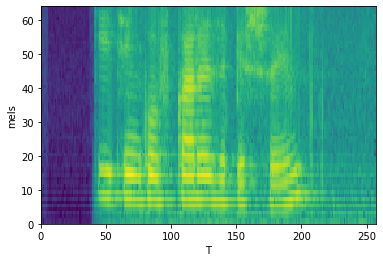

In [38]:
audio, audio_len = open_audio('test_files/test_audio.opus', sample_rate)
spectrogram, new_len = compute_log_mel_spectrogram(audio, torch.tensor(audio_len), sample_rate=sample_rate)
plt.pcolormesh(spectrogram)
plt.xlabel('T')
plt.ylabel('mels')
plt.show()
Audio(data=audio.numpy(), rate=sample_rate)

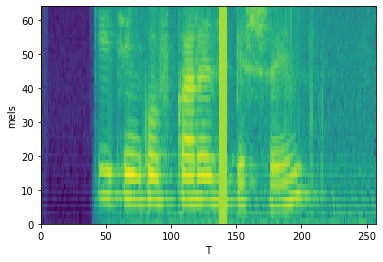

In [39]:
audio, audio_len = open_audio('test_files/test_audio.opus', sample_rate)
spectrogram, new_len = compute_log_mel_spectrogram(
    audio, torch.tensor(audio_len), sample_rate=sample_rate,
    spectrogram_transform=SpectrogramTransform(freq_mask_param=10, time_mask_param=20)
)
plt.pcolormesh(spectrogram)
plt.xlabel('T')
plt.ylabel('mels')
plt.show()
Audio(data=audio.numpy(), rate=sample_rate)

# Нейронная сеть

Мы подготовили все данные, теперь можно заняться реализацией нейронной сети. Будем реализовывать архитектуру [Deepspeech 2](https://arxiv.org/pdf/1512.02595.pdf) в немного упрощенном виде.


<img src="images/cat_reproduction.jpg" width="400" height="400">


Вот так будет выглядеть архитектура сети:


<img src="images/deepspeech.jpg" width="200" height="150">

In [40]:
num_tokens = len(vocab.tokens2indices()) - 1
num_mel_bins = 64
hidden_size= 512
num_layers = 4

In [41]:
model = Model(num_mel_bins=num_mel_bins,
              hidden_size=hidden_size,
              num_layers=num_layers,
              num_tokens=num_tokens)

In [62]:
! pytest tests/test_model.py

Don't forget to save Jupyter Notebook! 


============================= test session starts ==============================
platform linux -- Python 3.6.9, pytest-6.2.2, py-1.10.0, pluggy-0.13.1
rootdir: /home/mnakhodnov/sirius-stt, configfile: pytest.ini
collected 5 items                                                              

tests/test_model.py .....                                                [100%]

============================== 5 passed in 2.96s ===============================


Инициализируем модель из чекпоинта, чтобы она обучилась быстрее.

In [42]:
def load_from_ckpt(model, ckpt_path):
    checkpoint = torch.load(ckpt_path, map_location='cpu')
    model.load_state_dict(checkpoint['model_state_dict'])

In [43]:
load_from_ckpt(model, '/home/e.chuykova/data/ckpt.pt')

Тест, чтобы проверить, что код модели корректно написан, модель правильно восстановилась из чекпоинта

In [44]:
audio, audio_len = open_audio('test_files/test_audio.mp3', 8000)
output = model(*compute_log_mel_spectrogram(
    torch.unsqueeze(audio, 0), torch.unsqueeze(torch.tensor([audio_len]), 0), window_step=0.01
))
assert torch.isclose(output[0][0][0][0], torch.tensor(-3.53916406))
assert torch.isclose(output[0][15][0][30], torch.tensor(-3.605963468))

Отправим модель на гпу.

<img src="images/cuda_is_important.jpg" width="400" height="400">


# Обучаем модельку

## Декодинг

Давайте напишем несколько вспомогательных функций, которые будут нам нужны для обучения модели.

Для начала займемся метриками. Основная метрика - wer (word error rate).

Тут поможет библиотека `editdistance`.

In [65]:
! pytest tests/test_compute_wer.py

Don't forget to save Jupyter Notebook! 


============================= test session starts ==============================
platform linux -- Python 3.6.9, pytest-6.2.2, py-1.10.0, pluggy-0.13.1
rootdir: /home/mnakhodnov/sirius-stt, configfile: pytest.ini
collected 7 items                                                              

tests/test_compute_wer.py .......                                        [100%]

============================== 7 passed in 1.78s ===============================


Давайте реализуем greedy decoding. 

Сначала научимся получать greedy trn из выравниваний. Можно использовать `itertools`.

Не забудьте выкинуть лишние пробелы в начале и конце полученного текста!

In [68]:
! pytest tests/test_decode.py

Don't forget to save Jupyter Notebook! 


============================= test session starts ==============================
platform linux -- Python 3.6.9, pytest-6.2.2, py-1.10.0, pluggy-0.13.1
rootdir: /home/mnakhodnov/sirius-stt, configfile: pytest.ini
collected 4 items                                                              

tests/test_decode.py ....                                                [100%]

============================== 4 passed in 1.76s ===============================


Получим greedy text из выхода акустической модели (logprobs).

In [45]:
if os.path.exists('./models/1/epoch_6.pt'):
    load_from_ckpt(model, './models/1/epoch_6.pt')

In [46]:
# batch = next(iter(common_voice_val_dataloader))
batch = next(iter(open_stt_test_dataloader))
# batch = next(iter(ls_train_dataloader))

log_mel_spectrogram, seq_lens = compute_log_mel_spectrogram(batch['audios'], batch['audio_lens'], sample_rate=sample_rate)
logprobs, seq_lens = model(log_mel_spectrogram, seq_lens)

In [81]:
print(get_prediction(logprobs=logprobs, logprobs_lens=seq_lens, vocab=vocab, decoder=greedy_decoder))

['какое т примирения', 'н сто что может тоеделаеть', 'ес вам сейчас предложили', 'в двва государств нихузика', 'да них нелезиот делать став', 'всему общество важнознать', 'очн усвоки выше', 'сделатьс', 'у меня сусаци саранско еволюций', 'отретцали вседа последнего момента', 'ы не будем расширять надоное восток', 'торктрожелает чт есть закон', 'тогда почему', 'ко это возможно потому что', 'н один воскличне удивить', 'ему оставатясва', 'ки вут белые узбекти', 'л покужаются наминистра', 'сил того что у фидичски может', 'на это тему что он', 'покаживал пирваюми торый конол', 'а елена романову понимателе', 'тода этого луико исчизает', 'ереещева поностью', 'икогда пришел посл унверстета', 'два три слушаена попавшухся', 'вто что ни вноват это будт', 'воспринималась как', 'ня ни пожняиче нахротил со мальчик', 'ве понятно в целом', 'оторые государств остановила', 'очеть чтло не делает всего', 'никакое осубый тайны', 'этозначает что нужна достатчно', 'веэто мне кажто что житель', 'вроссии сегодн

In [82]:
beam_kwargs = {'beam_size': 10, 'cutoff_top_n': 1, 'cutoff_prob': None, 'ext_scoring_func': None, 'alpha': 1.0}

In [83]:
print(get_prediction(
    logprobs=logprobs, logprobs_lens=seq_lens, vocab=vocab, 
    decoder=beam_search_decode, decoder_kwargs=beam_kwargs
))

[' какое т примирения', 'н  сто  что  может тоеделаеть', 'ес  вам  сейчас  предложили', 'в двва  государств  нихузика', 'да них  нелезиот  делать  став', 'всему  общество  важнознать', 'очн  усвоки выше', 'сделатьс', '  у меня  сусаци  саранско  еволюций', ' отретцали вседа последнего  момента', 'ы  не будем  расширять  надоное восток', 'торктрожелает  чт  есть  закон', ' тогда  почему  ', 'ко  это возможно  потому  что', 'н один  воскличне  удивить', '  ему  оставатясва', 'ки вут  белые  узбекти', 'л  покужаются  наминистра', '  сил  того  что  у  фидичски  может', 'на это  тему  что  он', 'покаживал  пирваюми  торый конол', 'а  елена  романову  понимателе', 'тода  этого  луико  исчизает', 'ереещева  поностью', 'икогда  пришел  посл  унверстета', 'два  три  слушаена  попавшухся', 'вто что  ни вноват  это  будт', 'воспринималась  как', 'ня  ни пожняиче нахротил со мальчик', 'ве понятно  в  целом', 'оторые государств  остановила', 'очеть чтло  не делает всего', '  никакое осубый  тайны'

In [84]:
fast_beam_kwargs = {
    'beam_size': 10, 'cutoff_top_n': 1, 'cutoff_prob': 1.0, 
    'ext_scoring_func': None, 'alpha': 1.0, 'beta': 0.0, 'num_processes': 16
}

In [85]:
print(get_prediction(
    logprobs=logprobs, logprobs_lens=seq_lens, vocab=vocab, 
    decoder=fast_beam_search_decode, decoder_kwargs=fast_beam_kwargs
))

[' какое т примирения', 'н сто что может тоеделаеть', 'ес вам сейчас предложили', 'в двва государств нихузика', 'да них нелезиот делать став', 'всему общество важнознать', 'очн усвоки выше', 'сделатьс', ' у меня сусаци саранско еволюций', ' отретцали вседа последнего момента', 'ы не будем расширять надоное восток', 'торктрожелает чт есть закон', ' тогда почему ', 'ко это возможно потому что', 'н один воскличне удивить', ' ему оставатясва', 'ки вут белые узбекти', 'л покужаются наминистра', ' сил того что у фидичски может', 'на это тему  что он', 'покаживал пирваюми торый конол', 'а елена романову понимателе', 'тода этого луико исчизает', 'ереещева поностью', 'икогда пришел посл унверстета', 'два три слушаена попавшухся', 'вто что ни вноват это будт', 'воспринималась как', 'ня ни пожняиче нахротил со мальчик', 'ве понятно в целом', 'оторые государств остановила', 'очеть чтло не делает всего', ' никакое осубый тайны', ' этозначает что нужна достатчно', 'веэто мне кажто что житель', 'врос

In [86]:
! pytest tests/test_get_prediction.py

Don't forget to save Jupyter Notebook! 


============================= test session starts ==============================
platform linux -- Python 3.6.9, pytest-6.2.2, py-1.10.0, pluggy-0.13.1
rootdir: /home/mnakhodnov/sirius-stt, configfile: pytest.ini
collected 1 item                                                               

tests/test_get_prediction.py .                                           [100%]

============================== 1 passed in 1.78s ===============================


В этой функции надо из сырых данных, извлеченных из датасета, получить спектрограмму, прогнать через модель, посчитать средний лосс и wer для батча, list с текстами предсказанных гипотез для батча.

Для удобства будем логировать метрики в [tensorboard](https://pytorch.org/docs/stable/tensorboard.html).

Теперь можем собрать функции в train loop. 

## Training parameters

## Train LM model for beam search

In [47]:
with open('/data/mnakhodnov/language_data/common_voice/train.txt', 'w') as lm_data_file:
    for text in common_voice_test_dataset.data['text']:
        lm_data_file.write(text + '\n')

In [48]:
def preprocess_for_lm(document):
    document = document.lower()
    document = regex.sub(r'\P{Cyrillic}', ' ', document)
    document = regex.sub(' +', ' ', document)
    return document

In [ ]:
in_path = '/data/mnakhodnov/language_data/cc100/xaa'
with open(in_path, 'r') as data_file:
    with open(in_path + '.processed', 'w') as lm_data_file:
        n_documnets, current_document = 0, []
        for idx, line in enumerate(data_file):
            line = line.strip()
            if line == '':
                # End of document
                n_documnets += 1
                current_document = preprocess_for_lm(' '.join(current_document))
                if current_document != '':
                    lm_data_file.write(current_document + '\n')
                current_document = []
            else:
                # New paragraph in document
                current_document.append(line)

In [66]:
kenlm_bin_path = '/home/mnakhodnov/kenlm/build/bin'

kenlm_data_path = '/data/mnakhodnov/language_data/cc100/xaa.processed.2'
# kenlm_data_path = '/data/mnakhodnov/language_data/common_voice/train.txt'
kenlm_arpa_path, kenlm_binary_path = kenlm_data_path + '.arpa', kenlm_data_path + '.binary'

In [119]:
! $kenlm_bin_path/lmplz -o 5 -S 80% -T /data/mnakhodnov/language_data/tmp <$kenlm_data_path > $kenlm_arpa_path

=== 1/5 Counting and sorting n-grams ===
Reading /data/mnakhodnov/language_data/cc100/xaa.processed.4
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
****************************************************************************************************
Unigram tokens 331074 types 51186
=== 2/5 Calculating and sorting adjusted counts ===
Chain sizes: 1:614232 2:20103364608 3:37693812736 4:60310097920 5:87952228352
Statistics:
1 51186 D1=0.652332 D2=1.10365 D3+=1.4757
2 227275 D1=0.871749 D2=1.19501 D3+=1.48887
3 304511 D1=0.960632 D2=1.38513 D3+=1.60137
4 319924 D1=0.987147 D2=1.59434 D3+=1.60474
5 323468 D1=0.977654 D2=1.68627 D3+=1.24524
Memory estimate for binary LM:
type       kB
probing 26947 assuming -p 1.5
probing 32137 assuming -r models -p 1.5
trie    13244 without quantization
trie     7456 assuming -q 8 -b 8 quantization 
trie    12008 assuming -a 22 array pointer compression
trie     6220 assuming -a 22 -q 8 -b 8 array point

In [120]:
! $kenlm_bin_path/build_binary $kenlm_arpa_path $kenlm_binary_path

Reading /data/mnakhodnov/language_data/cc100/xaa.processed.4.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
****************************************************************************************************
SUCCESS


In [70]:
! $kenlm_bin_path/build_binary trie -q 7 -b 8 $kenlm_arpa_path $kenlm_binary_path

Reading /data/mnakhodnov/language_data/cc100/xaa.processed.2.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
****************************************************************************************************
Identifying n-grams omitted by SRI
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
****************************************************************************************************
Quantizing
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
****************************************************************************************************
Writing trie
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
****************************************************************************************************
SUCCESS


In [63]:
# load_from_ckpt(model, './models/2/epoch_6.pt')

In [71]:
beam_kwargs = {
    'beam_size': 10, 'cutoff_top_n': 5, 'cutoff_prob': None, 
    'ext_scoring_func': None, 'alpha': 1.0
}
fast_beam_kwargs = {
    'beam_size': 10, 'cutoff_top_n': 5, 'cutoff_prob': 1.0, 
    'ext_scoring_func': kenlm_binary_path, 'alpha': 1.0, 'beta': 0.3, 'num_processes': 32
}

In [74]:
model.eval()
loss, wer = validate(
    model, common_voice_val_dataloader, vocab, loss_fn,
#     decoder=greedy_decoder, decoder_kwargs={}
#     decoder=beam_search_decode, decoder_kwargs=beam_kwargs  
    decoder=fast_beam_search_decode, decoder_kwargs=fast_beam_kwargs
)
model.train()

print(f'Loss: {loss}, WER: {wer}')

# greedy -> Loss: 0.2857444478869438, WER: 0.3258212143412143
# fast_beam_search -> Loss: 0.2857444478869438, WER: 0.3172471955821956
# fast_beam_search + LM (1.0, 0.0) -> Loss: 0.2857444478869438, WER: 0.26591688394938395
# fast_beam_search + LM (1.0, 0.3) -> Loss: 0.2857444478869438, WER: 0.2645809271284272

## And for now we finally train model

In [57]:
num_epochs = 7
model_dir = 'models/5'
log_every_n_batch = 10

model = Model(
    num_mel_bins=num_mel_bins,
    hidden_size=hidden_size,
    num_layers=num_layers,
    num_tokens=num_tokens
)
# load_from_ckpt(model, '/home/e.chuykova/data/ckpt.pt')
load_from_ckpt(model, '/home/mnakhodnov/sirius-stt/models/2/epoch_5.pt')
model = model.to(device=device)

In [58]:
learning_rate = 2e-4
opt = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = torch.nn.CTCLoss(blank=blank_index, reduction='mean')

Про ctc loss очень хорошо написано [тут](https://distill.pub/2017/ctc/). А [это](https://www.cs.toronto.edu/~graves/icml_2006.pdf) исходная статья.

Если не используете перемешивание батчей (шафл), то при подборе batch size обратите внимание, что данные отсортированы (обучение будет замедляться с увеличением длины аудио).

In [54]:
# ls_train_dataloader.sampler.epoch = 0
# open_stt_train_dataloader.sampler.epoch = 0
# common_voice_train_dataloader.sampler.epoch = 0

In [60]:
num_epochs = 100

training(
    model=model, optimizer=opt, loss_fn=loss_fn, num_epochs=num_epochs, 
#     train_dataloader=[common_voice_train_dataloader, 'common_voice/train'],
#     train_dataloader=[ls_train_dataloader, 'libre_speech/train'],
    train_dataloader=[open_stt_train_dataloader, 'open_stt/train'],
    val_dataloaders={
        'open_stt/test': ls_test_dataloader,
        'libre_speech/dev': ls_dev_dataloader,
        'libre_speech/test': ls_test_dataloader,
        'common_voice/val': common_voice_val_dataloader,
    }, log_every_n_batch=log_every_n_batch, model_dir=model_dir, vocab=vocab,
    beam_kwargs=fast_beam_kwargs
)

<img src="images/training.jpeg" width="400" height="400">


После того, как напишете весь код и запустите обучение вашей первой модели, примерно после 5-6 эпох качество модели достигнет 30-35% WER.

# Как можно улучшить полученные результаты

<img src="images/pronunciation_or_not.jpg" width="400" height="400">

Далее описаны несколько способов, которые могут помочь улучшить качество. Потенциальный прирост обозначим ★, чем больше звездочек, тем более хорошее улучшение качества можно ожидать.

## Beam search ★★

На лекции обсуждали, что beam search помогает достичь более хорошего качества, чем greedy декодирование.

Изучить алгоритм можно [тут](https://medium.com/corti-ai/ctc-networks-and-language-models-prefix-beam-search-explained-c11d1ee23306) и [тут](https://drive.google.com/viewerng/viewer?url=https://arxiv.org/pdf/1408.2873.pdf)

Код для beam search посмотреть [тут](https://github.com/PaddlePaddle/DeepSpeech/blob/master/decoders/decoders_deprecated.py). (Отредактировать при необходимости )

## Внешняя языковая модель ★★★


Внешняя языковая модель позволяет улучшить качество, т.к. убирает условную независимость соседних символов, которая свойственна ctc лоссу.

Этот пункт состоит из двух этапов: сначала надо обучить языковую модель, затем встроить ее в beam search.

#### Обучение

Для обучения n-gram языковой модели можно использовать фреймворк kenlm.
Документация: 
* https://kheafield.com/code/kenlm/
* https://github.com/kpu/kenlm

Модель сначала строится в формате arpa, затем ее лучше перевести в формат trie. Вызывать полученную модель можно через питон [ссылка](https://github.com/kpu/kenlm#python-module)


#### Данные

Для обучения модели конечно нужны данные :) Тут есть варианты:

1. Можно обучить маленькую языковую модель на текстах из акустических обучающих данных (из трейна!).

минусы: этих данных мало

плюсы: домен остается таким же

2. Можно взять внешние данные, например, [отсюда](http://data.statmt.org/cc-100/). (46G).

минусы: тексты из другого (произвольного) домена

плюсы: данных много

При необходимости, данные надо предобработать - привести к нижнему регистру, разделить на предложения. Убрать предложения, которые содержат символы не из русского алфавита 


#### Внедрение в beam search

В разделе про beam search есть ссылки на алгоритм.

Можно использовать аргумент `ext_scoring_func` [тут](https://github.com/PaddlePaddle/DeepSpeech/blob/master/decoders/decoders_deprecated.py#L47).

Пример скорера можно найти [тут](https://github.com/PaddlePaddle/DeepSpeech/blob/master/decoders/scorer_deprecated.py)

## Аугментации ★


Позволяют искусственно увеличь размер обучающей выборки, сделать его более разнообразным.

### Аугментации аудио 

Применяются к аудиосигналу. Аугментации обычно реализуются через [sox](https://ru.wikipedia.org/wiki/SoX_(%D0%BF%D1%80%D0%BE%D0%B3%D1%80%D0%B0%D0%BC%D0%BC%D0%B0)). [Тут](http://sox.sourceforge.net/sox.html#EFFECTS) можно посмотротреть полный список sox эффектов с описанием. 

Полный список sox эффектов, доступных в torchaudio, можно посмотреть [тут](https://github.com/pytorch/audio/issues/260).

Эффекты можно комбинировать.

Внимание!

* Аугментации надо применять очень аккуратно (!) - слишком сильные аугментации только ухудшат качество. Лучше применять аугментации с некоторой вероятностью.
* Применять **только на обучающую выборку, не на валидацию!**
* Некоторые аугментации меняют sample rate и длину аудио.
* Можно применять не открывая предварительно аудиофайл [ссылка](https://pytorch.org/audio/stable/sox_effects.html#applying-effects-on-file).


Примеры:

In [ ]:
def augment_audio(audio, sample_rate, effects):
    
    effects = [effects, ['rate', '8000']]

    augmented_audio, sample_rate = torchaudio.sox_effects.apply_effects_tensor(
        torch.unsqueeze(audio, 0),
        sample_rate=sample_rate,
        effects=effects,
        channels_first=True)
    
    return augmented_audio

In [ ]:
sample_rate = 8000
audio, audio_len = open_audio('test_files/test_audio.mp3', sample_rate)
Audio(data=audio.numpy(), rate=sample_rate)

In [ ]:
augmented_audio = augment_audio(audio, sample_rate, ['treble', '20'])
Audio(data=augmented_audio.numpy(), rate=sample_rate)

In [ ]:
augmented_audio = augment_audio(audio, sample_rate, ['bass', '20'])
Audio(data=augmented_audio.numpy(), rate=sample_rate)

In [ ]:
augmented_audio = augment_audio(audio, sample_rate, ['pitch', '400'])
Audio(data=augmented_audio.numpy(), rate=sample_rate)

In [ ]:
augmented_audio = augment_audio(audio, sample_rate, ['speed', '1.5'])
Audio(data=augmented_audio.numpy(), rate=sample_rate)

In [ ]:
augmented_audio = augment_audio(audio, sample_rate, ['tempo', '1.5'])
Audio(data=augmented_audio.numpy(), rate=sample_rate)

### Аугментации спектрограммы

[SpecAugment: A Simple Data Augmentation Method for Automatic Speech Recognition](https://arxiv.org/pdf/1904.08779.pdf)

Методов [Frequency masking](https://pytorch.org/audio/stable/transforms.html#frequencymasking) и [Time masking](https://pytorch.org/audio/stable/transforms.html#timemasking) должно быть достаточно.

# Что еще можно попробовать: 

1. Поэкспериментировать с learning rate, оптимайзером (например, взять SGD). Можно добавить [lr decay](https://pytorch.org/docs/stable/optim.html#torch.optim.lr_scheduler.ExponentialLR) ★
2. Поэкспериментировать с нейронной сетью и восттановлением из чекпоинта. Например, зафиксировать предобученные слои и дообучить остальные, потом с маленьким learning rate дообучить всю модель. ★
3. Добавить новые слои в нейронную сеть. ★★
4. Использовать больше данных. ★★★
<img src="images/more_data.jpg" width="400" height="400">

В этом случае для ускорения можно запустить распределенное обучение на нескольких gpu с помощью [horovod](https://github.com/horovod/horovod). Данные можно взять тут:

* [open_stt](https://github.com/snakers4/open_stt) (до 2.5 TB данных!)
* [Russian LibriSpeech](https://openslr.org/96/) (9 GB данных)


5\. Не использовать чекпоинт и обучить свою сеть :) ★ (потребуется больше данных!)

6\. Shallow fusion - можно обучить дополнительную языковую модель и использовать в качестве рескорера 
[ссылка](https://arxiv.org/pdf/1503.03535.pdf). ★

7\. Реализовать перемешивание батчей. ★
